In [33]:
# !pip install pytorch-fid
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as D
import torchvision
from torch.nn.functional import adaptive_avg_pool2d
from torchvision import transforms
from tqdm import tqdm

from pytorch_fid.fid_score import calculate_frechet_distance
from pytorch_fid.inception import InceptionV3


def get_activations_of_imgs(img_dat, model, batch_size=50, dims=2048, device="cpu"):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- img_dat     : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    if batch_size > len(img_dat):
        print(
            (
                "Warning: batch size is bigger than the data size. "
                "Setting batch size to data size"
            )
        )
        batch_size = len(img_dat)

    dl = torch.utils.data.DataLoader(
        img_dat, batch_size=batch_size, drop_last=False, num_workers=1
    )
    pred_arr = np.empty((len(img_dat), dims))

    start_idx = 0

    for batch in tqdm(dl):
        batch = batch.to(device)

        with torch.no_grad():
            pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred = pred.squeeze(3).squeeze(2).cpu().numpy()

        pred_arr[start_idx : start_idx + pred.shape[0]] = pred

        start_idx = start_idx + pred.shape[0]

    return pred_arr


def calculate_activation_statistics_of_imgs(
    img_dat, model, batch_size=50, dims=2048, device="cpu"
):
    """Calculation of the statistics used by the FID.
    Params:
    -- img_dat
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- device      : Device to run calculations
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations_of_imgs(img_dat, model, batch_size, dims, device)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def _compute_statistics_of_imgs(img_dat, model, batch_size, dims, device):
    m, s = calculate_activation_statistics_of_imgs(
        img_dat, model, batch_size, dims, device
    )
    return m, s


def calculate_fid_given_images(img_dat1, img_dat2, batch_size, device, dims=2048):
    """Calculates the FID of two paths"""
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx]).to(device)

    m1, s1 = _compute_statistics_of_imgs(img_dat1, model, batch_size, dims, device)
    m2, s2 = _compute_statistics_of_imgs(img_dat2, model, batch_size, dims, device)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value

In [34]:
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size, leaky=0.2):
        super(Discriminator, self).__init__()
        # 728 -> 256
        self.linear1 = nn.Linear(image_size, hidden_size)
        self.bm1 = nn.BatchNorm1d(hidden_size)
        self.lr = nn.LeakyReLU(0.2)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.bm2 = nn.BatchNorm1d(hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.bm1(x)
        x = self.lr(x)
        x = self.linear2(x)
        x = self.bm2(x)
        x = self.lr(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x


class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(latent_size, hidden_size)
        # 64 -> 256
        self.relu = nn.ReLU()
        self.bm1 = nn.BatchNorm1d(hidden_size)
        self.bm2 = nn.BatchNorm1d(hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # 256->256
        self.linear3 = nn.Linear(hidden_size, image_size)
        # 256-> 728
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.linear1(x)
        x = self.bm1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.bm2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.tanh(x)
        return x

In [35]:
device = torch.device("cuda")

# Hyper-parameters
latent_size = 128
hidden_size = 256
image_size = 28 * 28
num_epochs = 200
batch_size = 100
learning_rate = 0.0002

In [36]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),  # 1 for greyscale channels
    ]
)
mnist = torchvision.datasets.FashionMNIST(
    root="./data/", train=True, transform=transform, download=True
)
data_loader = D.DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)


In [37]:
def testFID():
    num_samples = 3000
    real_imgs = None
    real_dl = iter(data_loader)
    while real_imgs is None or real_imgs.size(0) < num_samples:
        imgs = next(real_dl)
        if real_imgs is None:
            real_imgs = imgs[0]
        else:
            real_imgs = torch.cat((real_imgs, imgs[0]), 0)
    real_imgs = real_imgs[:num_samples].expand(-1, 3, -1, -1) * 0.5 + 0.5

    with torch.no_grad():
        samples = None
        while samples is None or samples.size(0) < num_samples:
            imgs = G.forward(torch.randn(batch_size, latent_size).to(device))
            if samples is None:
                samples = imgs
            else:
                samples = torch.cat((samples, imgs), 0)
    samples = samples.reshape(-1, 1, 28, 28)
    samples = samples[:num_samples].expand(-1, 3, -1, -1) * 0.5 + 0.5
    samples = samples.cpu()

    fid = calculate_fid_given_images(real_imgs, samples, batch_size, device)
    print("FID score: {:.3f}".format(fid), flush=True)

In [38]:
D = Discriminator(image_size, hidden_size, leaky=0.2).to(device)
G = Generator(latent_size, hidden_size, image_size).to(device)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

In [39]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        # calculates gradient
        d_loss.backward()
        # Update parameters
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i + 1) % 200 == 0:
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )   
            )

Epoch [0/200], Step [200/600], d_loss: 0.8510, g_loss: 1.0909, D(x): 0.66, D(G(z)): 0.35
Epoch [0/200], Step [400/600], d_loss: 0.6168, g_loss: 1.4183, D(x): 0.73, D(G(z)): 0.25
Epoch [0/200], Step [600/600], d_loss: 0.5120, g_loss: 1.5869, D(x): 0.79, D(G(z)): 0.23
Epoch [1/200], Step [200/600], d_loss: 0.4641, g_loss: 1.8940, D(x): 0.82, D(G(z)): 0.22
Epoch [1/200], Step [400/600], d_loss: 0.6437, g_loss: 1.6333, D(x): 0.70, D(G(z)): 0.21
Epoch [1/200], Step [600/600], d_loss: 0.5242, g_loss: 1.6734, D(x): 0.76, D(G(z)): 0.20
Epoch [2/200], Step [200/600], d_loss: 0.6648, g_loss: 1.4336, D(x): 0.70, D(G(z)): 0.24
Epoch [2/200], Step [400/600], d_loss: 0.5750, g_loss: 1.3228, D(x): 0.74, D(G(z)): 0.22
Epoch [2/200], Step [600/600], d_loss: 0.4600, g_loss: 1.6365, D(x): 0.79, D(G(z)): 0.18
Epoch [3/200], Step [200/600], d_loss: 0.4684, g_loss: 1.5896, D(x): 0.84, D(G(z)): 0.24
Epoch [3/200], Step [400/600], d_loss: 0.7312, g_loss: 1.7917, D(x): 0.67, D(G(z)): 0.24
Epoch [3/200], Step [

In [40]:
testFID()

d:\文档\PG-CSIT\ML\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
d:\文档\PG-CSIT\ML\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


FID score: 165.284


torch.Size([100, 784])


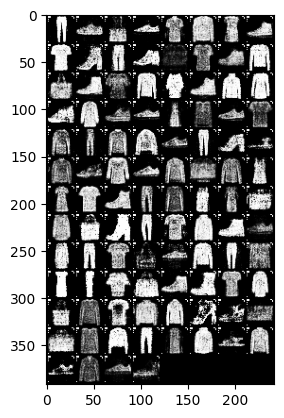

In [41]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


def denorm(x: torch.Tensor):
    # TANH (-1, 1) -> (0, 1)
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reshapeImgs(imgs):
    imgs = imgs.reshape(imgs.size(0), 1, 28, 28)
    imgs = make_grid(denorm(images)).cpu()
    imgs = imgs.transpose(0, 2).transpose(0, 1)
    return imgs


print(fake_images.shape)
fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
fake_images = make_grid(denorm(fake_images)).cpu()
plt.imshow(fake_images.transpose(0, 2).transpose(0, 1))
